In [1]:
import rasterio
from pathlib import Path 
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Data Check
## treepoint data list
- manup_treepoint.shp
- mandown_treepoint.shp
- br_rest1_treepoint.shp
- br_rest2_treepoint.shp

In [2]:
# 1. subclass change function
def sc_change(tp):
    # replace with *
    tp_sc = tp['subclass'].fillna('*')
    
    # subclass string to int
    tp_sc = tp_sc.to_frame()
    sc_list = {'subclass':{'Rosidae':'1', 'Hamamelididae':'2', 'Asteridae':'3',
                           'Dilleniidae':'4', 'Magnoliidae':'5', '*':'6'}}
    tp_sc = tp_sc.replace(sc_list)
    
    # change
    tp.drop(["subclass", "GenusSpeci", "OBJECTID", "Lat", "Long"], axis = 1, inplace=True)
    tp = pd.concat([tp, tp_sc], axis=1)
    
    return tp

In [3]:
## result: ['geo','subclass'(number)] || up(28273,2) down(24128,2) br(33398,2)

# 1. Point Sampling
- NDVI point smapling and Delete under 0.2
- Point Sampling

In [4]:
# 2. Set the feature & area
feature = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']
area = ['brleft']
# ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI'], 'outglcm_mandown'
# ['NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']'br', 'brleft', 'manup', 'brup', 'manmid' 'mandown'
for i in feature:
    for j in area:
        globals()[f'{i}{j}_file'] = '../KOMPSAT 위성영상/데이터 전처리/4. data/'+j+'/'+i+'.tif'
        globals()[f'{i}{j}_src'] = rasterio.open(globals()[f'{i}{j}_file'])

In [ ]:
# "mean", "variance", "homogeneity", "contrast",  "dissimilarity", "entropy", "second_moment", "correlation"
glcm = ["MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]
for i in glcm:
    for j in area:
        for k in range(1,9):
            globals()[f'GLCM{j}_file'] = '../KOMPSAT 위성영상/데이터 전처리/4. data/'+j+'/GLCM.tif'
            globals()[f'GLCM{j}_src'] = rasterio.open(globals()[f'GLCM{j}_file'])
            globals()[f'{i}{j}_src'] = globals()[f'GLCM{j}_src'].read(k)

In [5]:
## result: ['geo','subclass', 'NDVI'] || up(16979,3) down(15042,3) br(24028,3)

In [5]:
# 3. Point Sampling
def PointSampling(file, src, tp):
    # 가져올 픽셀의 좌표값 설정 (3by3)
    WIDTH = 0.00000599299783809013749338974087784241
    HEIGHT = 0.0000059299783809007439469768700121737
    coord_list0= [(x,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list1= [(x-WIDTH, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list2= [(x, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list3= [(x+WIDTH,y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list4= [(x+WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list5= [(x+WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list6= [(x,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list7= [(x-WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list8= [(x-WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list = [coord_list0, coord_list1, coord_list2, coord_list3, coord_list4, coord_list5, coord_list6, coord_list7, coord_list8]
    
    # 기존 tree point 정보를 복사한 변수를 0~8까지 생성: 각 9개 픽셀값을 넣을 변수임 ==============>>>>> 여기까진 확인
    for i in range(9):
        globals()[f'tp{i}'] = tp
    
    # 픽셀 9개 각각의 좌표값을 넣어서 tp[i]에 샘플링 값을 넣음. 
    for i in range(9):
        globals()[f'tp{i}'][Path(file).stem] = [x for x in src.sample(coord_list[i])] # 포인트 샘플링
        globals()[f'tp{i}'][Path(file).stem] = globals()[f'tp{i}'][Path(file).stem].astype('float64') # 픽셀값을 단순 float으로 바꿈

    # 각각의 픽셀값을 넣은 애들 합치기 (geo열은 기존 point의 geo이므로 걍 나중에 한번에 삭제)
#     tp08 = [tp0, tp1, tp2, tp3, tp4, tp5, tp6, tp7, tp8]
#     value = gpd.GeoDataFrame( pd.concat( tp08, ignore_index=True) ) 
    
#     return value # 하나의 feature의 9개 픽셀값을 아래로 데이터 추가한 결과라서 음.. brleft_NDVI 이런식으로 저장해야할듯
# 왜 이 코드가 없는데 brleft, 그러니까 tp에 샘플링값이 들어가지??? tp0에 넣는걸로 된거 아닌가......

In [ ]:
# 3. Point Sampling
def PointSampling(file, src, tp):
    # 가져올 픽셀의 좌표값 설정 (3by3)
    WIDTH = 0.00000599299783809013749338974087784241
    HEIGHT = 0.0000059299783809007439469768700121737
    coord_list0= [(x,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list1= [(x-WIDTH, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list2= [(x, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list3= [(x+WIDTH,y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list4= [(x+WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list5= [(x+WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list6= [(x,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list7= [(x-WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list8= [(x-WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list = [coord_list0, coord_list1, coord_list2, coord_list3, coord_list4, coord_list5, coord_list6, coord_list7, coord_list8]
    
    # tp에서 기존 geometry 열을 제거 후 복붙
    tp.drop(['geometry'], axis=1, inplace=True)
    tp = pd.concat([tp, tp, tp, tp, tp, tp, tp, tp, tp], axis=0, ignore_index=True)

    # 3by3에 대한 geometry를 dataframe에 column으로 추가
    tp['geometry'] = coord_list[0] + coord_list[1] + coord_list[2] + coord_list[3] + coord_list[4] + coord_list[5] + coord_list[6] + coord_list[7] + coord_list[8]

    # 해당 dataframe으로 포인트 샘플링 실행
    for i in range(9):
        tp[Path(NDVItp_file).stem] = [x for x in NDVItp_src.sample(tp['geometry'])] # 포인트 샘플링
        tp[Path(NDVItp_file).stem] = tp[Path(NDVItp_file).stem].astype('float64') # NDVI 값을 float으로 바꿈    

In [6]:
## 3by3 PS 한번에 돌리려고 했는데 모르겠음
# for i in ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI']:
#     for j in [up, down, br]:
#         PointSampling(globals()[f'{i}{j}_file'], globals()[f'{i}{j}_src'], globals()[f'{j}'])

# 2. Data pretreatment

In [5]:
# 4. delete the 3by3 kernel NDVI values under 0.2 
def NDVIkn02(tp):
    for i in range(9):
        tp.drop(tp[tp['NDVI']<0.2].index, inplace=True)
        tp.reset_index(drop=True, inplace=True)
    return tp

In [6]:
# 5. brleft, manup, mandown 의 subclass 1, 2 지우기
def scdel(tp):
    tp['subclass'] = tp['subclass'].astype(str)
    tem = tp.drop(tp[tp['subclass'] == '1'].index)
    tem = tem.drop(tem[tem['subclass'] == '2'].index)
    return tem

# 3. Run

In [7]:
# data load
# tp_up = gpd.GeoDataFrame.from_file("tree_points/manup_treepoint.shp")
# tp_mid = gpd.GeoDataFrame.from_file("tree_points/manmid.shp")
# tp_down = gpd.GeoDataFrame.from_file("tree_points/mandown_treepoint.shp")
# tp_br1 = gpd.GeoDataFrame.from_file("tree_points/br_rest1_treepoint.shp")
# tp_br2 = gpd.GeoDataFrame.from_file("tree_points/br_rest2_treepoint.shp")
# tp_brup = gpd.GeoDataFrame.from_file("tree_points/brup.shp")
tp_brleft = gpd.GeoDataFrame.from_file("tree_points/brleft.shp")
# tp_br = gpd.GeoDataFrame( pd.concat( [tp_br1, tp_br2], ignore_index=True) )

# tp_brtest = gpd.GeoDataFrame.from_file("tree_points/br_test_treepoint.shp")

In [8]:
# 1. run subclass change
# manup = sc_change(tp_up)
# mandown = sc_change(tp_down)
# br = sc_change(tp_br)
brleft = sc_change(tp_brleft)
# brtest = sc_change(tp_brtest)

In [9]:
brleft

,geometry,subclass
0,POINT (-73.98725 40.58878),1
1,POINT (-74.01690 40.62580),1
2,POINT (-73.98464 40.61303),2
3,POINT (-73.99436 40.57874),2
4,POINT (-74.00240 40.64618),2
...,...,...
43086,POINT (-74.02269 40.63608),2
43087,POINT (-73.99966 40.59569),2
43088,POINT (-73.99469 40.59122),2
43089,POINT (-73.97656 40.60155),6


In [10]:
# def PointSampling(file, src, tp, feature):
# PointSampling(NDVIbrleft_file, NDVIbrleft_src, brleft, 'NDVI')
# PointSampling(GCIbrleft_file, GCIbrleft_src, brleft, 'GCI')
# PointSampling(AVIbrleft_file, AVIbrleft_src, brleft, 'AVI')
# PointSampling(SIPIbrleft_file, SIPIbrleft_src, brleft, 'SIPI')
# PointSampling(ARVIbrleft_file, ARVIbrleft_src, brleft, 'ARVI')
# PointSampling(EVIbrleft_file, EVIbrleft_src, brleft, 'EVI')
file = NDVIbrleft_file
src = NDVIbrleft_src
tp = brleft

In [11]:
# 가져올 픽셀의 좌표값 설정 (3by3)
WIDTH = 0.00000599299783809013749338974087784241
HEIGHT = 0.0000059299783809007439469768700121737
coord_list0= [(x,y) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list1= [(x-WIDTH, y+HEIGHT) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list2= [(x, y+HEIGHT) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list3= [(x+WIDTH,y+HEIGHT) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list4= [(x+WIDTH,y) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list5= [(x+WIDTH,y-HEIGHT) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list6= [(x,y-HEIGHT) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list7= [(x-WIDTH,y-HEIGHT) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list8= [(x-WIDTH,y) for x,y in zip(brleft['geometry'].x , brleft['geometry'].y)]
coord_list = [coord_list0, coord_list1, coord_list2, coord_list3, coord_list4, coord_list5, coord_list6, coord_list7, coord_list8]


In [17]:
# tp에서 기존 geometry 열을 제거 후 복붙
brleft.drop(['geometry'], axis=1, inplace=True)
brleft

KeyError: "['geometry'] not found in axis"

In [19]:
brleft = pd.concat([brleft, brleft, brleft, brleft, brleft, brleft, brleft, brleft, brleft], axis=0)
brleft

,subclass
0,1
1,1
2,2
3,2
4,2
...,...
43086,2
43087,2
43088,2
43089,6


In [25]:
# 3by3에 대한 geometry를 dataframe에 column으로 추가
brleft['geometry'] = coord_list[0] + coord_list[1] + coord_list[2] + coord_list[3] + coord_list[4] + coord_list[5] + coord_list[6] + coord_list[7] + coord_list[8]
brleft

,subclass,geometry
0,1,"(-73.98724505, 40.58878145)"
1,1,"(-74.01689881, 40.62580133)"
2,2,"(-73.98464003, 40.61303284)"
3,2,"(-73.99436425, 40.57873857)"
4,2,"(-74.00239675, 40.6461762)"
...,...,...
43086,2,"(-74.02269649299784, 40.6360818)"
43087,2,"(-73.99966847299784, 40.59568966)"
43088,2,"(-73.99469438299784, 40.5912155)"
43089,6,"(-73.97656502299785, 40.60155267)"


In [26]:
# 해당 dataframe으로 포인트 샘플링 실행
for i in range(9):
    brleft[Path(NDVIbrleft_file).stem] = [x for x in NDVIbrleft_src.sample(brleft['geometry'])] # 포인트 샘플링
    brleft[Path(NDVIbrleft_file).stem] = brleft[Path(NDVIbrleft_file).stem].astype('float64') # NDVI 값을 float으로 바꿈
brleft

,subclass,geometry,NDVI
0,1,"(-73.98724505, 40.58878145)",-0.014300
1,1,"(-74.01689881, 40.62580133)",0.542790
2,2,"(-73.98464003, 40.61303284)",0.161142
3,2,"(-73.99436425, 40.57873857)",0.066769
4,2,"(-74.00239675, 40.6461762)",0.600314
...,...,...,...
43086,2,"(-74.02269649299784, 40.6360818)",-0.003243
43087,2,"(-73.99966847299784, 40.59568966)",0.156988
43088,2,"(-73.99469438299784, 40.5912155)",0.308693
43089,6,"(-73.97656502299785, 40.60155267)",0.401852


In [12]:
brleft0[Path(NDVIbrleft_file).stem] = [x for x in NDVIbrleft_src.sample(coord_list[0])] # 포인트 샘플링
brleft0[Path(NDVIbrleft_file).stem] = brleft0[Path(NDVIbrleft_file).stem].astype('float64')
brleft0

,geometry,subclass,NDVI
0,POINT (-73.98725 40.58878),1,-0.014300
1,POINT (-74.01690 40.62580),1,0.542790
2,POINT (-73.98464 40.61303),2,0.161142
3,POINT (-73.99436 40.57874),2,0.066769
4,POINT (-74.00240 40.64618),2,0.600314
...,...,...,...
43086,POINT (-74.02269 40.63608),2,0.007943
43087,POINT (-73.99966 40.59569),2,0.191522
43088,POINT (-73.99469 40.59122),2,0.310752
43089,POINT (-73.97656 40.60155),6,0.423310


In [13]:
brleft1[Path(NDVIbrleft_file).stem] = [x for x in NDVIbrleft_src.sample(coord_list[1])] # 포인트 샘플링
brleft1[Path(NDVIbrleft_file).stem] = brleft1[Path(NDVIbrleft_file).stem].astype('float64')
brleft1

,geometry,subclass,NDVI
0,POINT (-73.98725 40.58878),1,-0.000181
1,POINT (-74.01690 40.62580),1,0.563556
2,POINT (-73.98464 40.61303),2,0.175163
3,POINT (-73.99436 40.57874),2,0.053403
4,POINT (-74.00240 40.64618),2,0.604986
...,...,...,...
43086,POINT (-74.02269 40.63608),2,-0.009623
43087,POINT (-73.99966 40.59569),2,0.107793
43088,POINT (-73.99469 40.59122),2,0.320983
43089,POINT (-73.97656 40.60155),6,0.363540


In [14]:
# 픽셀 9개 각각의 좌표값을 넣어서 brleft[i]에 샘플링 값을 넣음.
for i in range(9):
    globals()[f'brleft{i}'][Path(NDVIbrleft_file).stem] = [x for x in NDVIbrleft_src.sample(coord_list[i])] # 포인트 샘플링
    globals()[f'brleft{i}'][Path(NDVIbrleft_file).stem] = globals()[f'brleft{i}'][Path(NDVIbrleft_file).stem].astype('float64') # NDVI 값을 float으로 바꿈
brleft_NDVI = gpd.GeoDataFrame( pd.concat( [brleft0, brleft1, brleft2, brleft3, brleft4, brleft5, brleft6, brleft7, brleft8], ignore_index=True) ) 
# 각각의 픽셀값을 넣은 애들 합치기 (geo열은 기존 point의 geo이므로 걍 나중에 한번에 삭제)
brleft_NDVI

,geometry,subclass,NDVI
0,POINT (-73.98725 40.58878),1,-0.010120
1,POINT (-74.01690 40.62580),1,0.542790
2,POINT (-73.98464 40.61303),2,0.161142
3,POINT (-73.99436 40.57874),2,0.069906
4,POINT (-74.00240 40.64618),2,0.600314
...,...,...,...
387814,POINT (-74.02269 40.63608),2,-0.003243
387815,POINT (-73.99966 40.59569),2,0.156988
387816,POINT (-73.99469 40.59122),2,0.308693
387817,POINT (-73.97656 40.60155),6,0.401852


In [15]:
# 3. run 3by3 PointSampling
# 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI'
# 'NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI'
# manup
PointSampling(NDVImanup_file, NDVImanup_src, manup, 'NDVI')
PointSampling(GCImanup_file, GCImanup_src, manup, 'GCI')
PointSampling(AVImanup_file, AVImanup_src, manup, 'AVI')
PointSampling(SIPImanup_file, SIPImanup_src, manup, 'SIPI')
PointSampling(ARVImanup_file, ARVImanup_src, manup, 'ARVI')
PointSampling(EVImanup_file, EVImanup_src, manup, 'EVI')

In [56]:
## Run ver2 PointSampling
# PointSampling(NDVImandown_file, NDVImandown_src, mandown, 'NDVI')
# PointSampling(GCImandown_file, GCImandown_src, mandown, 'GCI')
# PointSampling(AVImandown_file, AVImandown_src, mandown, 'AVI')
# PointSampling(SIPImandown_file, SIPImandown_src, mandown, 'SIPI')
# PointSampling(ARVImandown_file, ARVImandown_src, mandown, 'ARVI')
# PointSampling(EVImandown_file, EVImandown_src, mandown, 'EVI')

# PointSampling(NDVImanup_file, NDVImanup_src, manup, 'NDVI')
# PointSampling(GCImanup_file, GCImanup_src, manup, 'GCI')
# PointSampling(AVImanup_file, AVImanup_src, manup, 'AVI')
# PointSampling(SIPImanup_file, SIPImanup_src, manup, 'SIPI')
# PointSampling(ARVImanup_file, ARVImanup_src, manup, 'ARVI')
# PointSampling(EVImanup_file, EVImanup_src, manup, 'EVI')

# PointSampling(NDVIbr_file, NDVIbr_src, br, 'NDVI')
# PointSampling(GCIbr_file, GCIbr_src, br, 'GCI')
# PointSampling(AVIbr_file, AVIbr_src, br, 'AVI')
# PointSampling(SIPIbr_file, SIPIbr_src, br, 'SIPI')
# PointSampling(ARVIbr_file, ARVIbr_src, br, 'ARVI')
# PointSampling(EVIbr_file, EVIbr_src, br, 'EVI')

# PointSampling(NDVIbrleft_file, NDVIbrleft_src, brleft, 'NDVI')
# PointSampling(GCIbrleft_file, GCIbrleft_src, brleft, 'GCI')
# PointSampling(AVIbrleft_file, AVIbrleft_src, brleft, 'AVI')
# PointSampling(SIPIbrleft_file, SIPIbrleft_src, brleft, 'SIPI')
# PointSampling(ARVIbrleft_file, ARVIbrleft_src, brleft, 'ARVI')
# PointSampling(EVIbrleft_file, EVIbrleft_src, brleft, 'EVI')

In [16]:
# mandown
PointSampling(NDVImandown_file, NDVImandown_src, mandown, 'NDVI')
PointSampling(GCImandown_file, GCImandown_src, mandown, 'GCI')
PointSampling(AVImandown_file, AVImandown_src, mandown, 'AVI')
PointSampling(SIPImandown_file, SIPImandown_src, mandown, 'SIPI')
PointSampling(ARVImandown_file, ARVImandown_src, mandown, 'ARVI')
PointSampling(EVImandown_file, EVImandown_src, mandown, 'EVI')

In [17]:
# br
PointSampling(NDVIbr_file, NDVIbr_src, brtest, 'NDVI')
PointSampling(GCIbr_file, GCIbr_src, brtest, 'GCI')
PointSampling(AVIbr_file, AVIbr_src, brtest, 'AVI')
PointSampling(SIPIbr_file, SIPIbr_src, brtest, 'SIPI')
PointSampling(ARVIbr_file, ARVIbr_src, brtest, 'ARVI')
PointSampling(EVIbr_file, EVIbr_src, brtest, 'EVI')

In [18]:
# brleft 
PointSampling(NDVIbrleft_file, NDVIbrleft_src, brleft1, brleft2)
PointSampling(SBIbrleft_file, SBIbrleft_src, brleft)
# PointSampling(GVIbrleft_file, GVIbrleft_src, brleft)
# PointSampling(YVIbrleft_file, YVIbrleft_src, brleft)
# PointSampling(WBIbrleft_file, WBIbrleft_src, brleft)
# PointSampling(GCIbrleft_file, GCIbrleft_src, brleft)
# PointSampling(AVIbrleft_file, AVIbrleft_src, brleft)
# PointSampling(SIPIbrleft_file, SIPIbrleft_src, brleft)
# PointSampling(ARVIbrleft_file, ARVIbrleft_src, brleft)
# PointSampling(EVIbrleft_file, EVIbrleft_src, brleft)

In [18]:
# br
PointSampling(NDVIbr_file, NDVIbr_src, br, 'NDVI')
PointSampling(GCIbr_file, GCIbr_src, br, 'GCI')
PointSampling(AVIbr_file, AVIbr_src, br, 'AVI')
PointSampling(SIPIbr_file, SIPIbr_src, br, 'SIPI')
PointSampling(ARVIbr_file, ARVIbr_src, br, 'ARVI')
PointSampling(EVIbr_file, EVIbr_src, br, 'EVI')

In [15]:
print(coordlist[0][:4])
print(coordlist[1][:4])
print(coordlist[2][:4])

[(-74.01689881, 40.62580133), (-74.00239675, 40.6461762), (-73.99990001, 40.59673985), (-74.01359988, 40.61128287)]
[(-74.01690480299784, 40.62580725997838), (-74.00240274299784, 40.64618212997838), (-73.99990600299785, 40.59674577997838), (-74.01360587299784, 40.611288799978375)]
[(-74.01689881, 40.62580725997838), (-74.00239675, 40.64618212997838), (-73.99990001, 40.59674577997838), (-74.01359988, 40.611288799978375)]


In [13]:
PointSampling(NDVIbrleft_file, NDVIbrleft_src, brleft)

In [19]:
brleft

,geometry,subclass,NDVI,SBI
0,POINT (-73.98725 40.58878),1,-0.010120,0.415155
1,POINT (-74.01690 40.62580),1,0.542790,0.352799
2,POINT (-73.98464 40.61303),2,0.161142,0.281301
3,POINT (-73.99436 40.57874),2,0.069906,0.323050
4,POINT (-74.00240 40.64618),2,0.600314,0.328113
...,...,...,...,...
43086,POINT (-74.02269 40.63608),2,-0.003243,0.479209
43087,POINT (-73.99966 40.59569),2,0.156988,0.230397
43088,POINT (-73.99469 40.59122),2,0.308693,0.315201
43089,POINT (-73.97656 40.60155),6,0.401852,0.364530


In [15]:
tp0

,geometry,subclass,NDVI
0,POINT (-74.01690 40.62580),1,0.542790
1,POINT (-74.00240 40.64618),2,0.600314
2,POINT (-73.99990 40.59674),2,0.530797
3,POINT (-74.01360 40.61128),1,0.562556
4,POINT (-73.99292 40.63271),2,0.572526
...,...,...,...
28815,POINT (-74.00950 40.60074),6,0.517610
28816,POINT (-73.99041 40.58320),2,0.559967
28817,POINT (-73.99469 40.59122),2,0.308693
28818,POINT (-73.97656 40.60155),6,0.401852


In [16]:
tp1

,geometry,subclass,NDVI
0,POINT (-74.01690 40.62580),1,0.542790
1,POINT (-74.00240 40.64618),2,0.600314
2,POINT (-73.99990 40.59674),2,0.530797
3,POINT (-74.01360 40.61128),1,0.562556
4,POINT (-73.99292 40.63271),2,0.572526
...,...,...,...
28815,POINT (-74.00950 40.60074),6,0.517610
28816,POINT (-73.99041 40.58320),2,0.559967
28817,POINT (-73.99469 40.59122),2,0.308693
28818,POINT (-73.97656 40.60155),6,0.401852


In [20]:
for i in range(9):
    globals()[f'tp{i}'] = brleft

In [ ]:
# 픽셀 9개 각각의 좌표값을 넣어서 tp[i]에 샘플링 값을 넣음. 
for i in range(9):
    globals()[f'tp{i}'][Path(file).stem] = [x for x in src.sample(coord_list[i])] # 포인트 샘플링
    globals()[f'tp{i}'][Path(file).stem] = globals()[f'tp{i}'][Path(file).stem].astype('float64')

In [ ]:
PointSampling(SBIbrleft_file, SBIbrleft_src, brleft)

In [18]:
#확인
brleft

,geometry,subclass,NDVI
0,POINT (-74.01690 40.62580),1,0.542790
1,POINT (-74.00240 40.64618),2,0.600314
2,POINT (-73.99990 40.59674),2,0.506332
3,POINT (-74.01360 40.61128),1,0.584431
4,POINT (-73.99292 40.63271),2,0.648286
...,...,...,...
28815,POINT (-74.00950 40.60074),6,0.517326
28816,POINT (-73.99041 40.58320),2,0.571518
28817,POINT (-73.99469 40.59122),2,0.310752
28818,POINT (-73.97656 40.60155),6,0.423310


In [21]:
tp1

,geometry,subclass,NDVI
0,POINT (-74.01690 40.62580),1,0.542790
1,POINT (-74.00240 40.64618),2,0.600314
2,POINT (-73.99990 40.59674),2,0.506332
3,POINT (-74.01360 40.61128),1,0.584431
4,POINT (-73.99292 40.63271),2,0.648286
...,...,...,...
28815,POINT (-74.00950 40.60074),6,0.517326
28816,POINT (-73.99041 40.58320),2,0.571518
28817,POINT (-73.99469 40.59122),2,0.310752
28818,POINT (-73.97656 40.60155),6,0.423310


In [22]:
tp2

,geometry,subclass,NDVI
0,POINT (-74.01690 40.62580),1,0.542790
1,POINT (-74.00240 40.64618),2,0.600314
2,POINT (-73.99990 40.59674),2,0.506332
3,POINT (-74.01360 40.61128),1,0.584431
4,POINT (-73.99292 40.63271),2,0.648286
...,...,...,...
28815,POINT (-74.00950 40.60074),6,0.517326
28816,POINT (-73.99041 40.58320),2,0.571518
28817,POINT (-73.99469 40.59122),2,0.310752
28818,POINT (-73.97656 40.60155),6,0.423310


In [65]:
print(brleft_merge.columns)
# print(manup.columns, mandown.columns, br.columns, brleft.columns, brtest.columns)
## result: [출력결과 확인] || up(16979,47) down(15042,47) br(24028,47)

RangeIndex(start=0, stop=75, step=1)


In [21]:
# 4. run delete the 3by3 kernel NDVI values under 0.2 
brtest = NDVIkn02(brtest)
manup = NDVIkn02(manup)
mandown = NDVIkn02(mandown)
brleft = NDVIkn02(brleft)
br = NDVIkn02(br)

In [22]:
## result: [같음] || up(15057,47) down(13409,47) br(21971,47)

In [23]:
manup.drop(['geometry'], axis = 1, inplace=True)
mandown.drop(['geometry'], axis = 1, inplace=True)
br.drop(['geometry'], axis = 1, inplace=True)
brleft.drop(['geometry'], axis = 1, inplace=True)
mandown

,subclass,NDVI0,NDVI1,NDVI2,NDVI3,NDVI4,NDVI5,NDVI6,NDVI7,NDVI8,...,YVI8,WBI0,WBI1,WBI2,WBI3,WBI4,WBI5,WBI6,WBI7,WBI8
1,1,0.610439,0.562178,0.585266,0.568741,0.607949,0.620719,0.624810,0.604821,0.591637,...,-0.009734,-0.013966,-0.018572,-0.016770,-0.017633,-0.014538,-0.012910,-0.011927,-0.012488,-0.014729
2,1,0.423846,0.494278,0.435812,0.404347,0.398452,0.407033,0.459979,0.482630,0.470416,...,-0.011459,-0.028486,-0.019441,-0.025333,-0.027976,-0.030023,-0.030338,-0.024822,-0.023420,-0.023403
8,1,0.315406,0.379775,0.377538,0.373157,0.291602,0.201947,0.253879,0.252509,0.320808,...,-0.010628,-0.018235,-0.016197,-0.016101,-0.016728,-0.014798,-0.022777,-0.021076,-0.021096,-0.017345
9,6,0.253490,0.229874,0.242919,0.242919,0.268116,0.249478,0.265961,0.255578,0.243387,...,-0.056597,-0.039669,-0.041651,-0.037001,-0.037001,-0.038725,-0.040039,-0.038853,-0.039195,-0.039457
10,1,0.634895,0.596301,0.596301,0.636861,0.667508,0.666212,0.667438,0.635335,0.621389,...,-0.025912,-0.006668,-0.010121,-0.010121,-0.007041,-0.003515,-0.002861,-0.002940,-0.006053,-0.007190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112,4,0.710760,0.612913,0.699723,0.544407,0.566911,0.641944,0.786801,0.859582,0.811516,...,0.016995,-0.002253,-0.004717,-0.001604,-0.012341,-0.012663,-0.007631,0.000652,0.003226,0.002078
24113,2,0.247676,0.240268,0.244050,0.255254,0.256054,0.271645,0.276003,0.299487,0.256842,...,-0.019210,-0.030961,-0.023976,-0.026360,-0.026418,-0.029275,-0.026791,-0.026560,-0.022038,-0.026877
24121,1,0.413353,0.356041,0.330912,0.409870,0.391277,0.577737,0.481077,0.493339,0.450082,...,-0.021465,-0.026478,-0.029435,-0.024865,-0.006390,-0.022523,-0.010988,-0.021784,-0.024800,-0.026241
24123,3,0.275474,0.321883,0.309113,0.331701,0.286348,0.247396,0.257025,0.257025,0.275897,...,0.015586,-0.010896,-0.009838,-0.009900,-0.009174,-0.010831,-0.011616,-0.010849,-0.010849,-0.010575


In [54]:
###### 각 지역의 data에 대해 csv 생성 #####
brtest.to_csv('./dataCSV/br_test_ver2.csv', index=False)
manup.to_csv('./dataCSV/manup_training_ver2.csv', index=False)
mandown.to_csv('./dataCSV/mandown_training_ver2.csv', index=False)
brleft.to_csv('./dataCSV/brleft_training_ver2.csv', index=False)
br.to_csv('./dataCSV/br_training_ver2.csv', index=False)

In [ ]:
##################################################

In [33]:
# 스파이더로 만든 ver2 가져오기
manup = pd.read_csv('./dataCSV/manup_training_ver2.csv')
mandown = pd.read_csv('./dataCSV/mandown_training_ver2.csv')
brleft = pd.read_csv('./dataCSV/brleft_training_ver2.csv')
br = pd.read_csv('./dataCSV/br_training_ver2.csv')

In [34]:
# 5. delete subclass '1', '2'
brleft_del = scdel(brleft)
manup_del = scdel(manup)
mandown_del = scdel(mandown)
br_del = scdel(br)

In [35]:
# 예진이가 만든 manmid, brup 불러오기
manmid = pd.read_csv('./dataCSV/manmid_training_ver2.csv')
brup = pd.read_csv('./dataCSV/brup_training_ver2.csv')

In [36]:
manmid_del = scdel(manmid)
brup_del = scdel(brup)

In [37]:
# concat all tp 
tpall = gpd.GeoDataFrame( pd.concat( [manup_del, mandown_del, br_del, brleft_del, manmid, brup_del], ignore_index=True) )
#tpall.to_csv('all_training.csv', index=False)

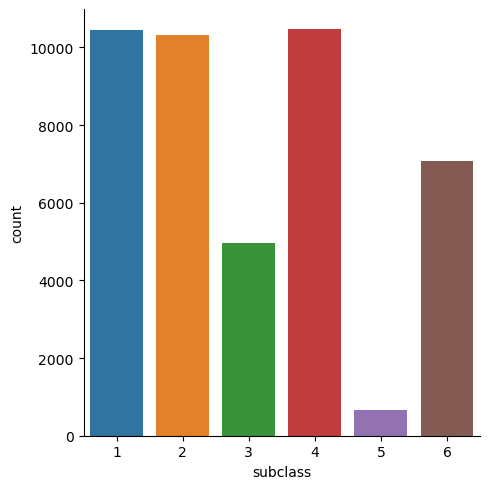

(10455, 56) (10318, 56) (4972, 56) (10467, 56) (668, 56) (7069, 56)


In [38]:
sns.catplot(x="subclass", kind="count", order=['1', '2', '3', '4', '5', '6'], data=tpall) # order: 보여지는 순서
plt.show()
# 분류항목 확인
for i in range(1, 7):
    globals()[f'sc{i}'] = tpall[tpall['subclass'] == str(i)]
print(sc1.shape, sc2.shape, sc3.shape, sc4.shape, sc5.shape, sc6.shape)

In [39]:
tpall.to_csv('./dataCSV/all_training_ver2.csv', index=False)

In [53]:
tpall
# result: 50437 rows × 46 columns

,subclass,NDVI0,NDVI1,NDVI2,NDVI3,NDVI4,NDVI5,NDVI6,NDVI7,NDVI8,...,YVI8,WBI0,WBI1,WBI2,WBI3,WBI4,WBI5,WBI6,WBI7,WBI8
0,3,0.464904,0.445488,0.473091,0.510326,0.492966,0.470867,0.462338,0.447882,0.465438,...,-0.025793,-0.023712,-0.024151,-0.021272,-0.016337,-0.019927,-0.023036,-0.022662,-0.022135,-0.021885
1,6,0.622866,0.627700,0.627700,0.592036,0.602341,0.619844,0.613144,0.607288,0.616141,...,-0.011950,-0.013503,-0.013142,-0.013142,-0.016172,-0.014747,-0.012225,-0.012940,-0.014615,-0.014480
2,6,0.485671,0.452899,0.387458,0.387458,0.414758,0.481439,0.531720,0.530093,0.536756,...,-0.015341,-0.024560,-0.025090,-0.033404,-0.033404,-0.030012,-0.020692,-0.019240,-0.022750,-0.019316
3,3,0.478828,0.475296,0.439229,0.440640,0.491810,0.556671,0.508831,0.528209,0.421745,...,-0.032468,-0.015789,-0.005387,-0.007839,-0.013497,-0.013025,-0.009255,-0.015647,-0.012939,-0.019699
4,3,0.377302,0.271617,0.244254,0.348663,0.406972,0.461839,0.504799,0.460585,0.377855,...,-0.015648,-0.022189,-0.031723,-0.038288,-0.025578,-0.025925,-0.025050,-0.020132,-0.018883,-0.021936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43944,5,0.475202,0.504286,0.522750,0.528241,0.496828,0.487972,0.433563,0.434048,0.468802,...,-0.037626,-0.020355,-0.017943,-0.015363,-0.015059,-0.018785,-0.016261,-0.023574,-0.024302,-0.022173
43945,6,0.460392,0.470885,0.493936,0.475196,0.422498,0.374210,0.355977,0.389782,0.453951,...,-0.020992,-0.028739,-0.021868,-0.023682,-0.030360,-0.033514,-0.038654,-0.038038,-0.028467,-0.024592
43946,5,0.707391,0.728033,0.728033,0.665958,0.695431,0.649497,0.640839,0.620106,0.642896,...,-0.020225,-0.004378,-0.002494,-0.002494,-0.007388,-0.005111,-0.009982,-0.011147,-0.013992,-0.010811
43947,6,0.505243,0.419842,0.480400,0.525081,0.530191,0.535845,0.439902,0.439902,0.430771,...,-0.029189,-0.008859,-0.016015,-0.010959,-0.007132,-0.009036,-0.008716,-0.016600,-0.016600,-0.016158


In [17]:
# td = up+br, test = down
tp_upbr = gpd.GeoDataFrame( pd.concat( [up, br], ignore_index=True) )
tp_upbr.drop(['geometry'], axis = 1, inplace=True)

In [22]:
tp_upbr.to_csv('upbr_training.csv', index=False)
down.to_csv('down_test.csv', index=False)

In [21]:
down

,subclass,NDVI0,NDVI1,NDVI2,NDVI3,NDVI4,NDVI5,NDVI6,NDVI7,NDVI8,...,YVI8,WBI0,WBI1,WBI2,WBI3,WBI4,WBI5,WBI6,WBI7,WBI8
1,1,0.610439,0.562178,0.585266,0.568741,0.607949,0.620719,0.624810,0.604821,0.591637,...,-0.009734,-0.013966,-0.018572,-0.016770,-0.017633,-0.014538,-0.012910,-0.011927,-0.012488,-0.014729
2,1,0.423846,0.494278,0.435812,0.404347,0.398452,0.407033,0.459979,0.482630,0.470416,...,-0.011459,-0.028486,-0.019441,-0.025333,-0.027976,-0.030023,-0.030338,-0.024822,-0.023420,-0.023403
8,1,0.315406,0.379775,0.377538,0.373157,0.291602,0.201947,0.253879,0.252509,0.320808,...,-0.010628,-0.018235,-0.016197,-0.016101,-0.016728,-0.014798,-0.022777,-0.021076,-0.021096,-0.017345
9,6,0.253490,0.229874,0.242919,0.242919,0.268116,0.249478,0.265961,0.255578,0.243387,...,-0.056597,-0.039669,-0.041651,-0.037001,-0.037001,-0.038725,-0.040039,-0.038853,-0.039195,-0.039457
10,1,0.634895,0.596301,0.596301,0.636861,0.667508,0.666212,0.667438,0.635335,0.621389,...,-0.025912,-0.006668,-0.010121,-0.010121,-0.007041,-0.003515,-0.002861,-0.002940,-0.006053,-0.007190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112,4,0.710760,0.612913,0.699723,0.544407,0.566911,0.641944,0.786801,0.859582,0.811516,...,0.016995,-0.002253,-0.004717,-0.001604,-0.012341,-0.012663,-0.007631,0.000652,0.003226,0.002078
24113,2,0.247676,0.240268,0.244050,0.255254,0.256054,0.271645,0.276003,0.299487,0.256842,...,-0.019210,-0.030961,-0.023976,-0.026360,-0.026418,-0.029275,-0.026791,-0.026560,-0.022038,-0.026877
24121,1,0.413353,0.356041,0.330912,0.409870,0.391277,0.577737,0.481077,0.493339,0.450082,...,-0.021465,-0.026478,-0.029435,-0.024865,-0.006390,-0.022523,-0.010988,-0.021784,-0.024800,-0.026241
24123,3,0.275474,0.321883,0.309113,0.331701,0.286348,0.247396,0.257025,0.257025,0.275897,...,0.015586,-0.010896,-0.009838,-0.009900,-0.009174,-0.010831,-0.011616,-0.010849,-0.010849,-0.010575
